# Validation
## Create nonlinear material behaviour

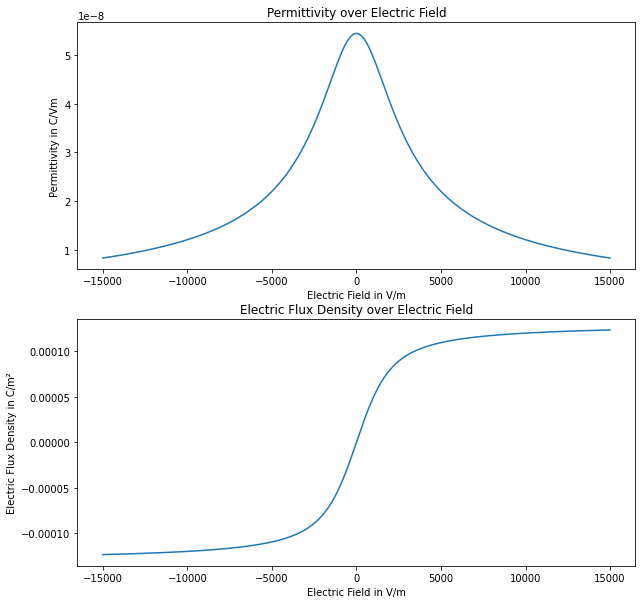

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

save=False

def L(x):
    import numpy as np
    coth = lambda x: 1.0/np.tanh(x)
    x = np.array(x)
    I0 = x==0
    vals = np.zeros_like(x)
    vals[~I0] = coth(x[~I0]) - 1.0/x[~I0]
    return vals 

E=np.linspace(-1.5e4,1.5e4,2**12)
epsilon=1.306e-8

#Nonlinear electric flux, Langevinfunction and scaled
D=L(E/800)*epsilon*1e4

#Epsilon function
def epsilon_nl(D,E):
    E_int = E
    E0= E==0
    ep_int=np.zeros_like(E)
    ep_int[~E0] = D[~E0]/E[~E0]
    #if division by zero -> delete entry
    for i, entry in enumerate(E0):
        if entry:
            E_int=np.delete(E_int,[i])
            ep_int=np.delete(ep_int,[i])
    #interpolate accordingly so inputsize matches outputsize
    epsilon=interpolate.interp1d(E_int,ep_int, kind='cubic')
    return epsilon(E)

#To interpolate Epsilon 
epsilon=interpolate.interp1d(E,epsilon_nl(D,E))

fig,ax = plt.subplots(2,figsize=(10,10))
ax[0].plot(E,epsilon(E))
ax[1].plot(E,epsilon(E)*E)

ax[0].set_xlabel('Electric Field in V/m')
ax[0].set_ylabel('Permittivity in C/Vm')
ax[0].set_title('Permittivity over Electric Field')

ax[1].set_xlabel('Electric Field in V/m')
ax[1].set_ylabel('Electric Flux Density in C/m²')
ax[1].set_title('Electric Flux Density over Electric Field')

if save:
    plt.savefig('Nonlinear_permittivity')

# Create Material data

In [2]:
#Only need positiv E-epsilon curve
E_pos=np.linspace(0,1.2e4,20)

E_ep=np.dstack((E_pos,epsilon(E_pos)))
E_ep=E_ep.reshape((E_ep.shape[1],E_ep.shape[2]))

newfile=open("E_ep.fnc","w")
np.savetxt('E_ep.fnc',E_ep)

## Run simulation

In [3]:
#Run simulation
import os
os.system("./run.sh")

0

## Read Data

In [4]:
import sys
sys.path.insert(1, '/home/alexander/Devel/CFS_SRC/CFS/share/python')
from hdf5_tools import get_result

elecFieldIntensity = get_result('./results_hdf5/UnitCubeNL.cfs','elecFieldIntensity',step='all')
elecFluxDensity = get_result('./results_hdf5/UnitCubeNL.cfs','elecFluxDensity',step='all')

#only y-direction important in this testcase
#elecField[Stepnumber,Elements,xyz]
elecFieldIntensity = elecFieldIntensity[:,:,1]
elecFluxDensity = elecFluxDensity[:,:,1]

StepN = elecFieldIntensity.shape[0]
ElementN = elecFieldIntensity.shape[1]

## Validation

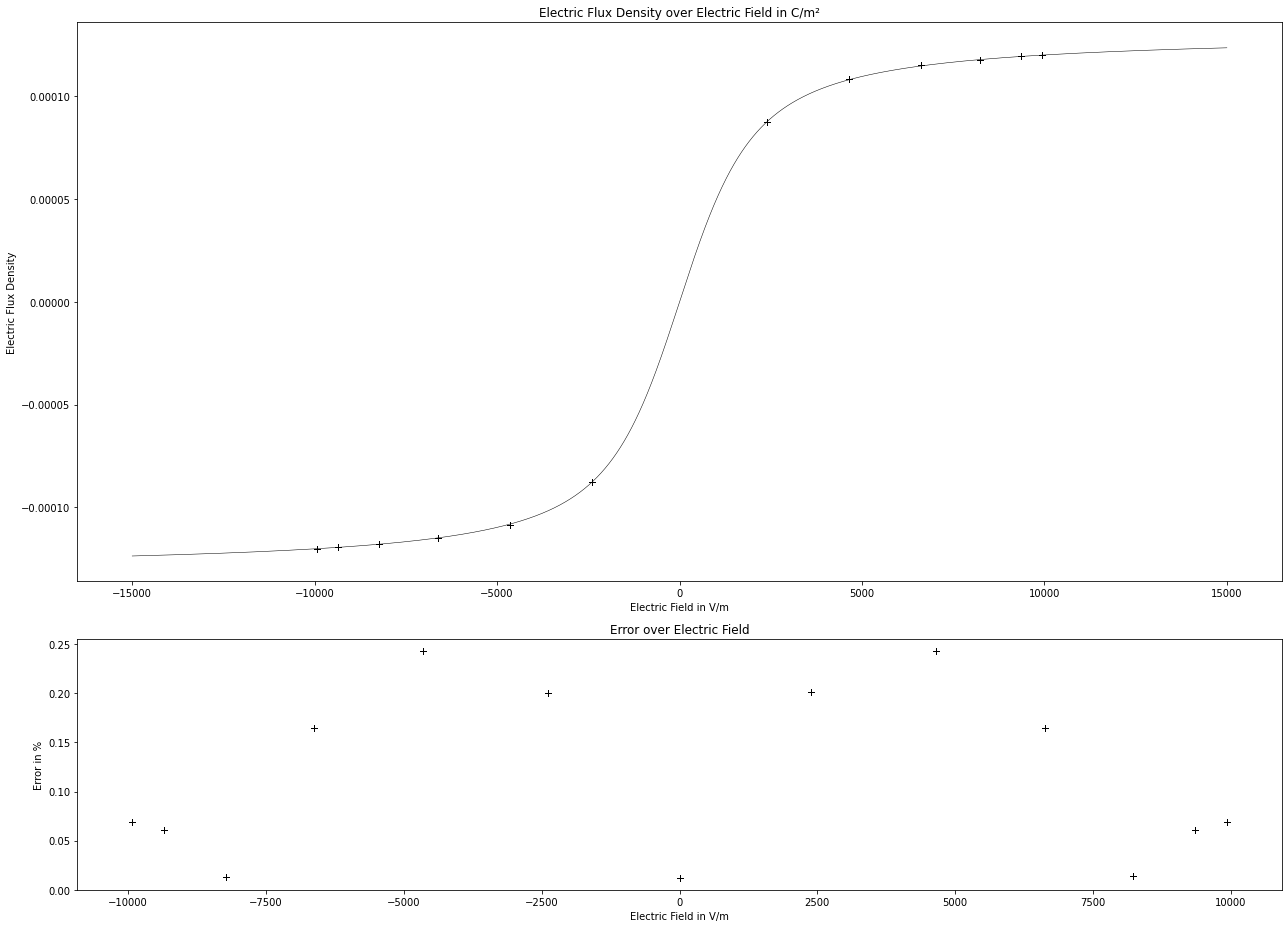

In [5]:
fig, ax = plt.subplots(figsize=(18,13))

ax1=plt.subplot(3,2,(1,4))
ax1.set_xlabel('Electric Field in V/m')
ax1.set_ylabel('Electric Flux Density')
ax1.set_title('Electric Flux Density over Electric Field in C/m²')

ax2=plt.subplot(3,2,(5,6))
ax2.set_xlabel('Electric Field in V/m')
ax2.set_ylabel('Error in %')
ax2.set_title('Error over Electric Field')

ax1.plot(E,epsilon(E)*E,c='k',lw=0.5)
for step in range(StepN-1):
    for element in range(ElementN-1):
        ax1.plot(elecFieldIntensity[step,element],elecFluxDensity[step,element],marker='+',c='k')

Error=np.abs(epsilon(elecFieldIntensity)*elecFieldIntensity-elecFluxDensity)/np.abs(epsilon(elecFieldIntensity)*elecFieldIntensity)*100
ax2.plot(elecFieldIntensity,Error,c='k',lw=0,marker='+')

plt.tight_layout()
if save:
    plt.savefig('Validation')